In [1]:
from scipy import fft
from scipy import signal as sig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

In [2]:
# Read & prep data
df = pd.read_csv('../data/PA_911_calls.csv')
df = df.rename(columns = {k:k.lower() for k in df.columns})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_trunc'] = df['timestamp'].dt.floor('H')
df['N'] = 1

# Count calls per hour
counts = df.groupby(['timestamp_trunc']).sum()
counts = counts[['N']]

# Create time & signal, filling in missing hours with 0 calls
counts_dict = counts['N'].to_dict()
time = pd.date_range(min(counts.index), max(counts.index), freq = 'H').to_series().sort_values()
signal = time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)

# Set signal to be the difference of call volume from the average
signal = signal - signal.mean()

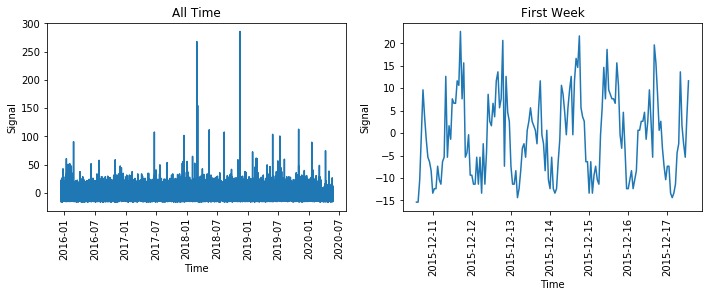

In [14]:
## Plot signal in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(time, signal, label='signal')
ax1.set_title('All Time')
ax1.set_ylabel( 'Signal' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 24 * 7

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(time[:N], signal[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Signal' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ]),
 <a list of 8 Text xticklabel objects>)

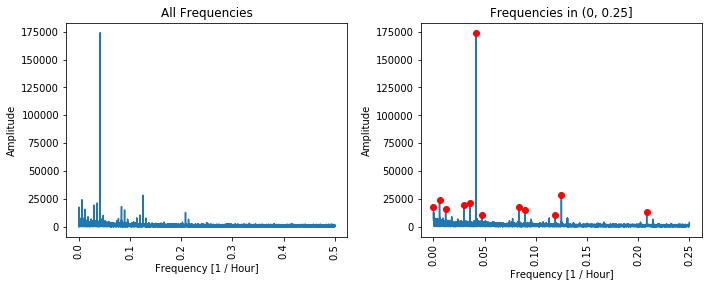

In [5]:
# Plotting power in the frequency domain
fft_output = fft.fft(signal)
power = np.abs(fft_output)
freq = fft.fftfreq(len(signal))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)

In [6]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

index  freq (1/hour)      amplitude  period (days)  \
5    1626       0.041673  174062.196850       0.999846   
10   4877       0.124994   28318.302537       0.333350   
1     232       0.005946   24288.857250       7.007543   
4    1394       0.035727   21381.880273       1.166248   
3    1161       0.029755   19584.292031       1.400301   
7    3251       0.083321   18170.858321       0.500077   
0       1       0.000026   17643.910281    1625.750000   
2     465       0.011918   15654.795178       3.496237   
8    3484       0.089292   15089.671405       0.466633   
11   8129       0.208340   12878.104889       0.199994   
9    4645       0.119048   10580.435617       0.350000   
6    1858       0.047619   10245.727655       0.875000   

                                          fft  
5    (120273.06713556127-125825.42546738203j)  
10    (9525.657550402704-26668.110296763436j)  
1     (7808.166028766332+22999.589774626198j)  
4    (-8264.466020719228-19720.126911236264j)  
3    (-17130.121636243366+9492.282500277372j)  
7   (-1690.5313486036412-18092.047863402855j)  
0   (-14079.836482350145+10633.239140738577j)  
2   (-15141.112012940219+3977.3532771080663j)  
8    (-3782.2287425987665-14607.97483786689j)  
11   (-1115.811819416283+12829.674567870848j)  
9     (-8794.236965438293-5882.772649091732j)  
6    (-94.17596641699004+10245.294825791354j)

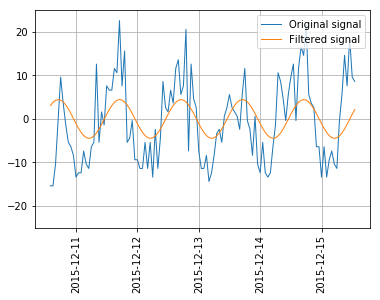

In [7]:
filtered_fft_output = np.array([f if i == 1626 else 0 for i, f in enumerate(fft_output)])
filtered_sig = fft.ifft(filtered_fft_output)

N = 24 * 5
plt.plot(time[:N], signal[:N], linewidth=1, label='Original signal')
plt.plot(time[:N], filtered_sig[:N].real, linewidth=1, label='Filtered signal')
plt.legend(loc='upper right')
ax2.set_title('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [8]:
filtered_sig_peaks = sig.find_peaks(filtered_sig.real, prominence=1)[0]
print('First 5 Peaks')
print(time[filtered_sig_peaks].apply(lambda d: d.weekday()).head())
print('-------------')
print('Last 5 Peaks')
print(time[filtered_sig_peaks].apply(lambda d: d.weekday()).tail())

First 5 Peaks
2015-12-10 17:00:00    3
2015-12-11 17:00:00    4
2015-12-12 17:00:00    5
2015-12-13 17:00:00    6
2015-12-14 17:00:00    0
dtype: int64
-------------
Last 5 Peaks
2020-05-18 11:00:00    0
2020-05-19 11:00:00    1
2020-05-20 11:00:00    2
2020-05-21 11:00:00    3
2020-05-22 11:00:00    4
dtype: int64


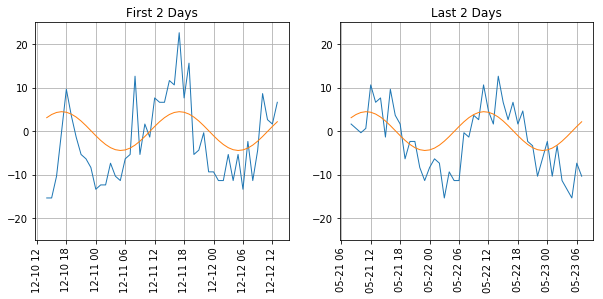

In [9]:
N = 24 * 2

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(time[:N], signal[:N], linewidth=1, label='Original signal')
ax1.plot(time[:N], filtered_sig[:N].real, linewidth=1, label='Filtered signal')
ax1.set_title('First 2 Days')

plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(time[-N:], signal[-N:], linewidth=1, label='Original signal')
ax2.plot(time[-N:], filtered_sig[-N:].real, linewidth=1, label='Filtered signal')
ax2.set_title('Last 2 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print('')